<a href="https://colab.research.google.com/github/lucianozablocki/tiny_md/blob/main/cp_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print(f"Length of original df: {len(df)}")
print("\nUnique values in each column:")
print(f"N values: {df['N'].unique()}")
print(f"opt flags: {df['opt'].unique()}")
print(f"compilers: {df['compiler'].unique()}")

Length of original df: 520

Unique values in each column:
N values: [  4  32 108 256 500]
opt flags: ['-O0' '-O1' '-O2' '-O3' '-Ofast']
compilers: ['gcc' 'clang']


In [ ]:
# Create a cross product of all possible combinations
compilers = ['gcc', 'clang']
opt_flags = ['-O0', '-O1', '-O2', '-O3', '-Ofast']
Ns = [4*m**3 for m in range(1,5+1)]  # [4, 32, 108, 256, 500]

# Create all possible combinations
all_combinations = pd.MultiIndex.from_product(
    [Ns, opt_flags, compilers],
    names=['N', 'opt', 'compiler']
).to_frame(index=False)

# Count measurements for each combination
counts = df.groupby(['N', 'opt', 'compiler']).size().reset_index(name='count')

# Merge to see which combinations have fewer than 5 measurements
analysis = all_combinations.merge(counts, how='left', on=['N', 'opt', 'compiler'])

# Print summary statistics
print("\nSummary:")
print(f"Total rows in df: {len(df)}")
print("\nMeasurement counts:")
print(analysis['count'].value_counts())


Summary:
Total rows in df: 520

Measurement counts:
count
20    10
15    10
10    10
5     10
2     10
Name: count, dtype: int64


In [84]:
def plot_results_for(file_name, df):
  plt.figure(figsize=(15, 6))
  #plt.title(file_name)

  df_max = df.groupby(['N', 'opt', 'compiler'])['particulas/s'].max().reset_index()
  df=df_max

  df_max2 = df.groupby(['N', 'compiler'])['particulas/s'].max().reset_index()
  print(df_max2)

  # Plot for GCC
  plt.subplot(1, 2, 1)
  for opt in df['opt'].unique():
      data = df[(df['compiler'] == 'gcc') & (df['opt'] == opt)]
      plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  plt.title('GCC Performance')
  plt.xlabel('N (number of particles)')
  plt.ylabel('Particles/s')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)

  plt.ylim(1, 1000)
  plt.xlim(0, 550)

  # Plot for Clang
  plt.subplot(1, 2, 2)
  for opt in df['opt'].unique():
      data = df[(df['compiler'] == 'clang') & (df['opt'] == opt)]
      plt.plot(data['N'], data['particulas/s'], 'o-', label=opt)

  plt.title('Clang Performance')
  plt.xlabel('N (number of particles)')
  plt.ylabel('Particles/s')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)

  plt.ylim(1, 1000)
  plt.xlim(0, 550)

  plt.suptitle(f'Results for {file_name}')

  # Adjust layout to prevent overlap
  plt.tight_layout()

Processing file: atom
     N compiler  particulas/s
0    4    clang       739.739
1    4      gcc       706.909
2   32    clang       378.033
3   32      gcc       378.422
4  108    clang       140.445
5  108      gcc       146.696
6  256    clang        41.250
7  256      gcc        42.426
8  500    clang        21.846
9  500      gcc        23.278
Processing file: atom-native
     N compiler  particulas/s
0    4    clang       769.660
1    4      gcc       829.170
2   32    clang       427.275
3   32      gcc       412.215
4  108    clang       154.314
5  108      gcc       177.365
6  256    clang        43.608
7  256      gcc        63.256
8  500    clang        23.303
9  500      gcc        35.041
Processing file: atom-native-float
     N compiler  particulas/s
0    4    clang       739.762
1    4      gcc       779.993
2   32    clang       398.916
3   32      gcc       395.344
4  108    clang       130.867
5  108      gcc       174.707
6  256    clang        42.621
7  256      gc

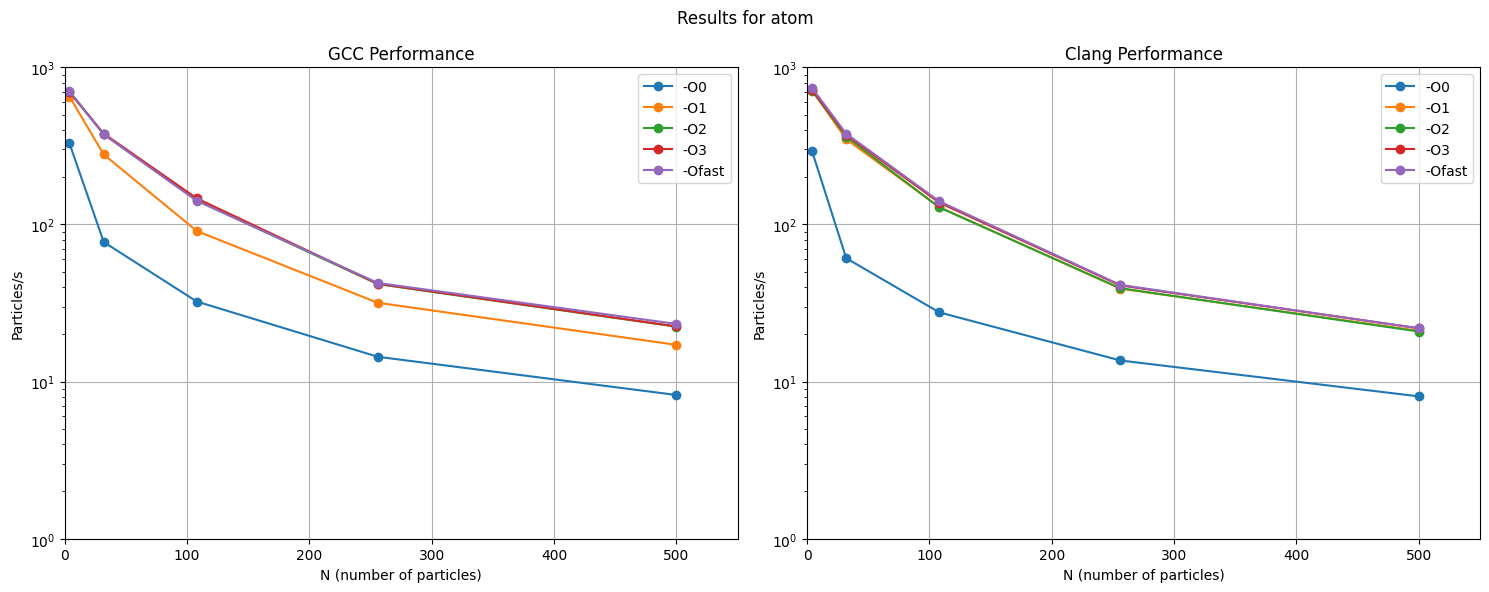

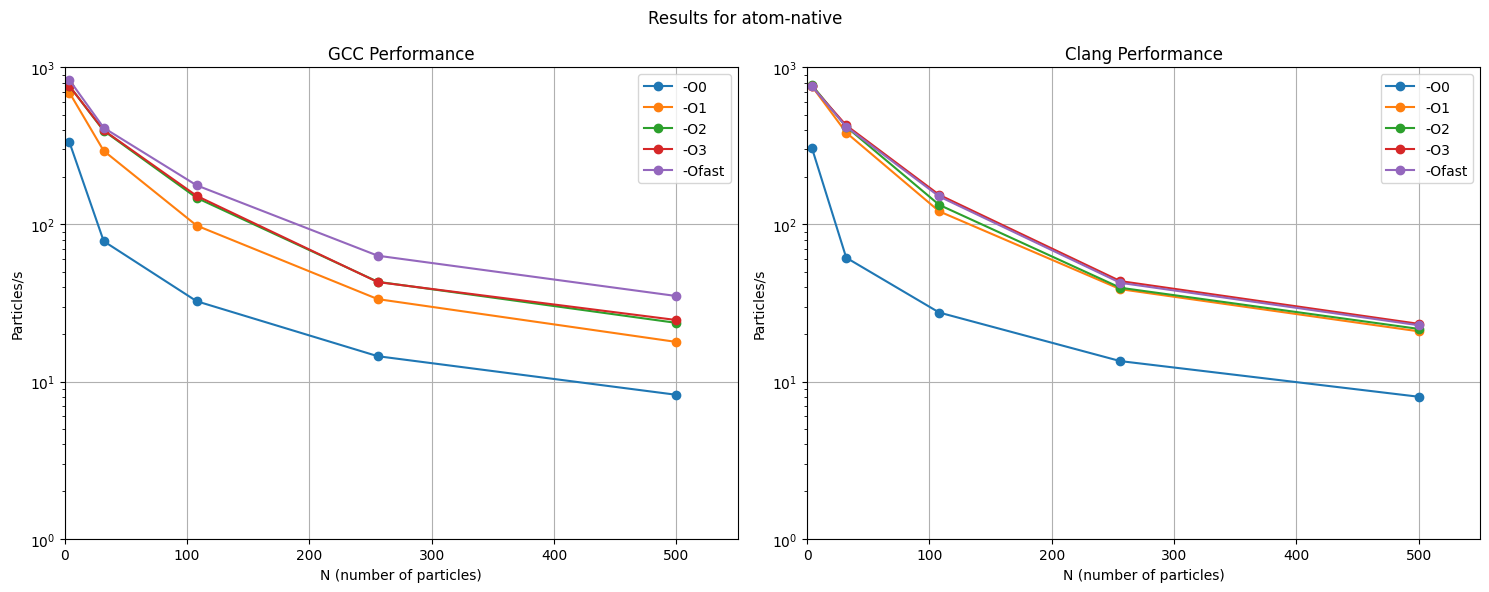

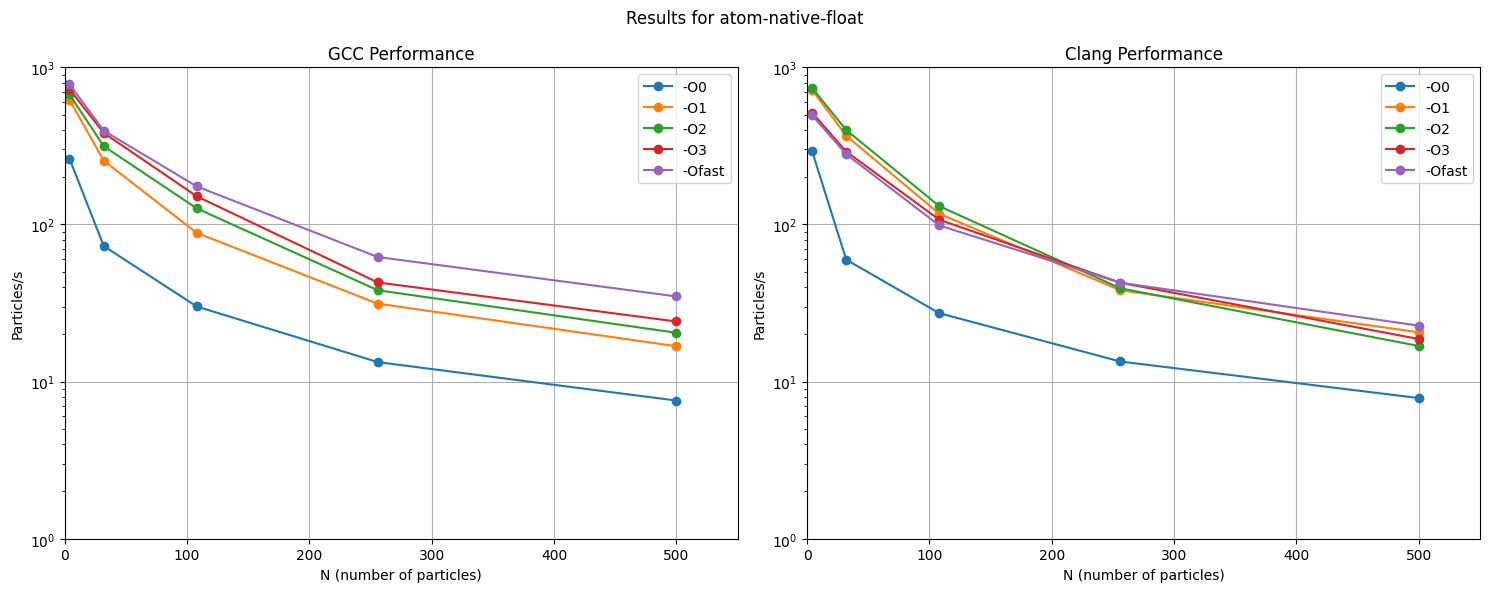

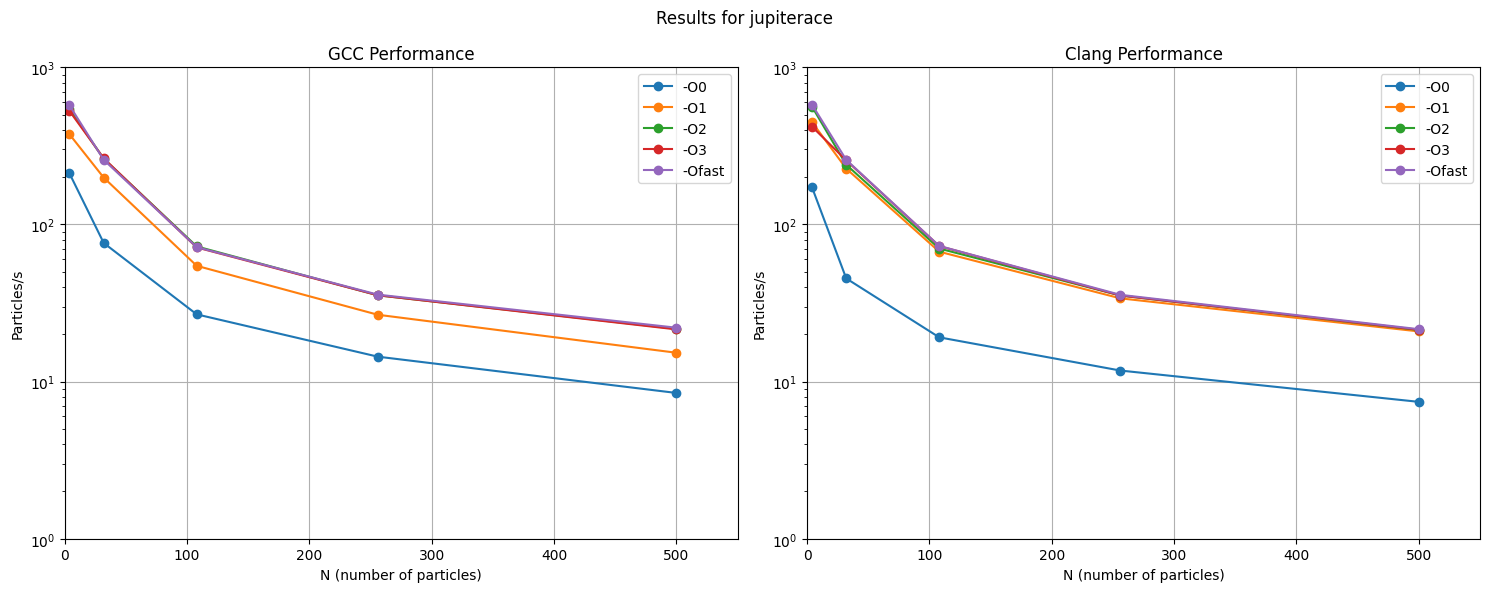

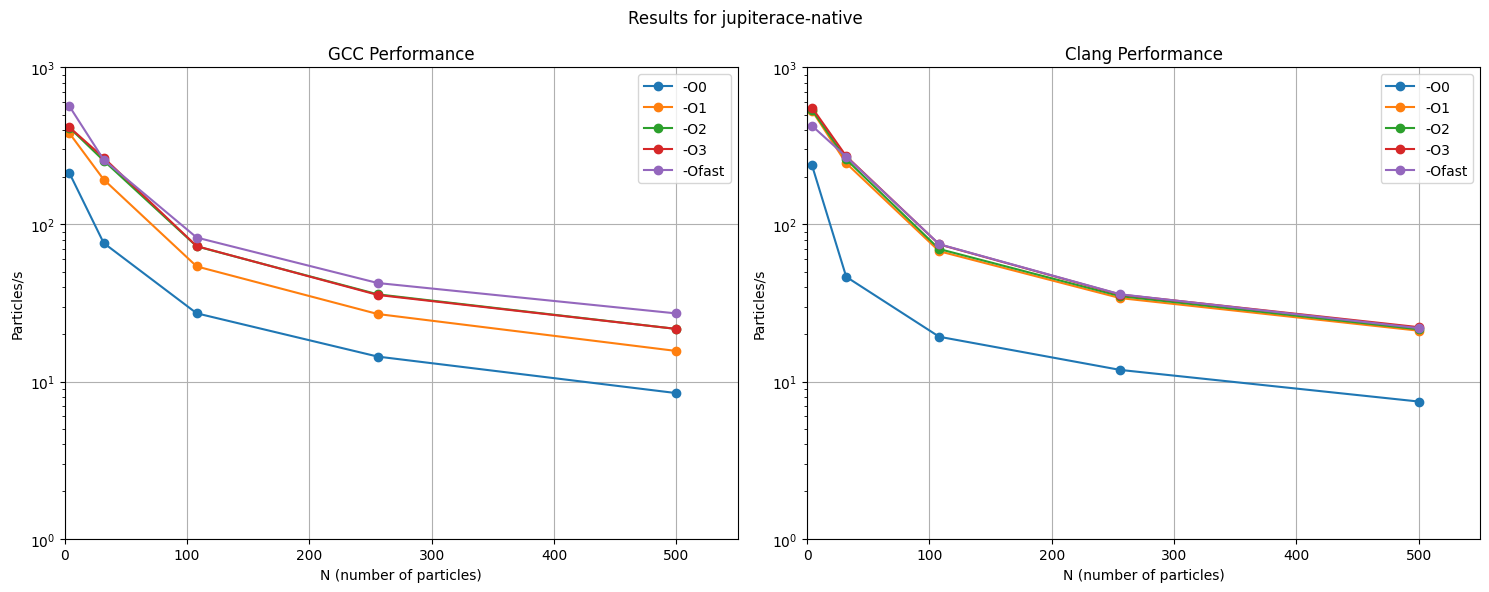

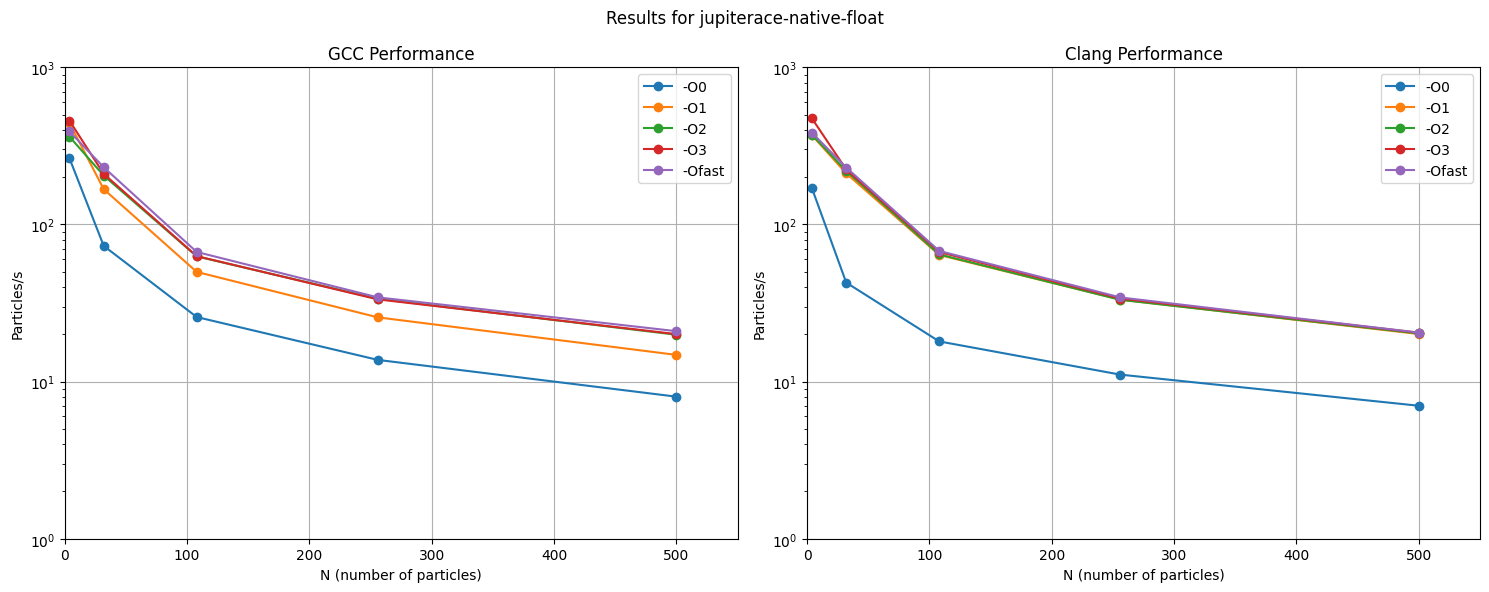

In [85]:
files = ['atom', 'atom-native', 'atom-native-float',
         'jupiterace', 'jupiterace-native', 'jupiterace-native-float']
df = None
for file_name in files:
  print(f"Processing file: {file_name}")
  df = pd.read_csv(f"https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/{file_name}.csv")
  plot_results_for(file_name, df)

In [91]:
def print_results_for(df):
  df_sorted = df.sort_values('particulas/s', ascending=False)
  df_max_per_N = df_sorted.groupby('N').first().reset_index()
  print(df_max_per_N)

In [92]:
files = ['atom', 'atom-native', 'atom-native-float',
         'jupiterace', 'jupiterace-native', 'jupiterace-native-float']
df = None
for file_name in files:
  print(f"Processing file: {file_name}")
  df = pd.read_csv(f"https://raw.githubusercontent.com/lucianozablocki/tiny_md/refs/heads/main/results/{file_name}.csv")
  print_results_for(df)

Processing file: atom
     N  particulas/s     opt compiler  runs
0    4       739.739  -Ofast    clang    20
1   32       378.422     -O3      gcc    15
2  108       146.696     -O3      gcc    10
3  256        42.426  -Ofast      gcc     5
4  500        23.278  -Ofast      gcc     2
Processing file: atom-native
     N  particulas/s     opt compiler  runs
0    4       829.170  -Ofast      gcc    20
1   32       427.275     -O3    clang    15
2  108       177.365  -Ofast      gcc    10
3  256        63.256  -Ofast      gcc     5
4  500        35.041  -Ofast      gcc     2
Processing file: atom-native-float
     N  particulas/s     opt compiler  runs
0    4       779.993  -Ofast      gcc    20
1   32       398.916     -O2    clang    15
2  108       174.707  -Ofast      gcc    10
3  256        62.056  -Ofast      gcc     5
4  500        34.839  -Ofast      gcc     2
Processing file: jupiterace
     N  particulas/s     opt compiler  runs
0    4       578.933  -Ofast    clang    20
1   32

In [ ]:
import pandas as pd

# Read the CSV file with tab separation
file_path = "/content/timeSGEMM-atom.txt"  # Replace with your file path
df = pd.read_csv(file_path, sep='\t', header=None, names=['size', 'time', 'MFLOPS'])

# Remove the 's' from time and ' MFLOPS' from MFLOPS and convert them to numeric
df['time'] = df['time'].str.replace(' s', '').astype(float)
df['MFLOPS'] = df['MFLOPS'].str.replace(' MFLOPS', '').astype(float)

# Group the data by 'size'
grouped = df.groupby('size')

# Calculate average time and MFLOPS for each size
avg_time = grouped['time'].mean()
avg_mflops = grouped['MFLOPS'].mean()

# Find the row with max MFLOPS for each size
max_mflops_row = grouped['MFLOPS'].idxmax()  # Find the index of the max MFLOPS per group
max_mflops_row = df.loc[max_mflops_row]  # Use the indices to get the corresponding rows

# Output the results
print("Average Time and MFLOPS per Size:")
print(f"Average Time:\n{avg_time}")
print(f"Average MFLOPS:\n{avg_mflops}")
print(f"Row with Max MFLOPS:\n{max_mflops_row}")

Average Time and MFLOPS per Size:
Average Time:
size
16384x16384x16384     4.343849
32768x32768x32768    31.902321
Name: time, dtype: float64
Average MFLOPS:
size
16384x16384x16384    2.027263e+06
32768x32768x32768    2.208652e+06
Name: MFLOPS, dtype: float64
Row with Max MFLOPS:
                 size       time        MFLOPS
8   16384x16384x16384   4.114502  2.137827e+06
19  32768x32768x32768  29.875342  2.355412e+06
